---
#Setup


## Download data

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/*DTSA 5800: Network Analysis/Network Analysis"
DATA_FILE = f"{PROJECT_DIR}/nikelululemonadidas_tweets.jsonl"

The following cell is a bash script to download and extract the data file to the project directory. Uncomment and run the script if you want to reproduce the results of this notebook.

**Note:** The script is dependent upon the `PROJECT_DIR` python variable (from the previous cell)



In [ ]:
# %%bash -s "$PROJECT_DIR"
# wget http://128.138.93.164/nikelululemonadidas_tweets.jsonl.gz -P "${1}"
# gzip -d "${1}/nikelululemonadidas_tweets.jsonl.gz"

## Dependencies

In [ ]:
import itertools
import json
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import string
from textblob import TextBlob
from time import time

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.0 MB/s 


In [ ]:
nltk.download("punkt") #punctuation tagging
nltk.download("stopwords")
nltk.download("omw-1.4")
nltk.download("wordnet")

from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Filter functions
Functions to filter tweets by user ID and/or sentiment

In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()
def match_tweet(tweet, user_ids=None, max_polarity=None, min_polarity=None):
    """Return boolean value of whether a tweet meets specified criteria.
    
    Match criteria:
      * user_ids (a list of user ids for tweet senders)
      * max/min_polarity (float between -1.0 and 1.0.  cut-offs for sentiment analysis)
    `None` values are interpreted as "match all"
    """
    if user_ids: 
        if len(user_ids) > 0:
            if tweet["user"]["id"] not in user_ids:
                return False

    if (max_polarity != None) or (min_polarity != None):
        try:
            text = tweet["full_text"]
        except:
            text = tweet["text"]
            
        polarity = sentiment_analyzer.polarity_scores(text)["compound"]
        if max_polarity != None:
            if polarity > max_polarity:
                return False
        if min_polarity != None:
            if polarity < min_polarity:
                return False

    return True


def filter_tweets(tweets, user_ids=None, max_polarity=None, min_polarity=None):
    """ Yields an iterable of dictionaries of tweets meeting specified criteria.
    
    See `match_tweet()` for details about filter parameters

    This function accepts an iterable of tweet objects which may either 
    be JSON strings, or previously parsed tweet dictionaries.
    """
    for tweet in tweets:
        if isinstance(tweet, (bytes, str)):
            tweet = json.loads(tweet)
        if match_tweet(tweet,
                       user_ids=user_ids,
                       max_polarity=max_polarity,
                       min_polarity=min_polarity):
            yield tweet

## Pre-processing functions
Functions to streamline tokenization, lemmatization, and stopword removal

In [ ]:
TWEET_TOKENIZER = nltk.TweetTokenizer().tokenize
def tokenize(text, lowercase=True):
    """Tokenize the text. By default, also normalizes text to lowercase."""
    if lowercase:
        text = text.lower()
    return TWEET_TOKENIZER(text)


LEMMATIZER = nltk.WordNetLemmatizer()
def lemmatize(tokens):
    """Lemmatize the tokens. Assumes all tokens are nouns unless tokens are passed as (word, pos) tuples."""
    lemmas = []
    for token in tokens:
        if isinstance(token, str):
            lemmas.append(LEMMATIZER.lemmatize(token)) # treats token like a noun
        else: # assume a tuple of (word, pos)
            lemmas.append(LEMMATIZER.lemmatize(*token))
    return lemmas


def remove_stopwords(tokens, stopwords=None):
    """Remove stopwords. Defaults to the default set of nltk english stopwords."""
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [ token for token in tokens if token not in stopwords ]


def remove_links(tokens):
    """Removes http/s links from the tokens. Assumes links are intact, E.g. the way the Tweet Tokenizer works."""
    return [ t for t in tokens
            if not t.startswith("http://")
            and not t.startswith("https://")]


def remove_handles(tokens):
    clean = []
    for t in tokens:
        if t[0] != "@":
            clean.append(t)
        elif t in ["@nike", "@adidas", "@lululemon"]:
            clean.append(t)
    return clean


punctuation = string.punctuation.replace('#','')
def remove_punctuation(tokens,
                       strip_mentions=False,
                       strip_hashtags=False,
                       strict=True):
    """Remove punctuation from a list of tokens.
    * strip_mentions=True will strip the @ off of @ mentions
    * strip_hashtags=True will strip the # from hashtags
    * strict=True will remove all punctuation except @ and # from ALL tokens
    """
    tokens = [t for t in tokens if t not in punctuation]
    if strip_mentions:
        tokens = [t.lstrip('@') for t in tokens]
    if strip_hashtags:
        tokens = [t.lstrip('#') for t in tokens]
    if strict:
        cleaned = []
        for t in tokens:
            t = t.replace('\u2026', '') #remove ellipsis
            t = t.replace('\u2019', '') #remove apostrophe
            cleaned.append(
                t.translate(str.maketrans('', '', punctuation)).strip()
            )
        tokens = [t for t in cleaned if t]
    return tokens

def remove_short(tokens, min_length=2):
    return [t for t in tokens if len(t) >= min_length]

---
# EDA

## Country code distribution

175078 Total tweets processed                      

169351 tweets with code: no country_code
5713 tweets with code: us
10 tweets with code: ca
1 tweets with code: tr
2 tweets with code: mx
1 tweets with code: gr




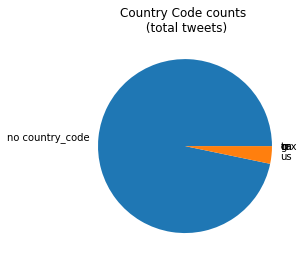

In [ ]:
# Look at the country_code distribution for our tweets
country_code_counts = {}
with open(DATA_FILE) as f:
    for i, line in enumerate(f):
        if i % 10000 == 0: # progress tracker
            print(f"\r Progress: {i//1000}k tweets processed", end="")
        tweet = json.loads(line)
        try: 
            cc = tweet["place"]["country_code"].lower()
        except: 
            cc = "no country_code"
        if cc not in country_code_counts:
            country_code_counts[cc] = 0
        country_code_counts[cc] += 1
    print(f"\r{i+1} Total tweets processed {' '*20} \n")

#display exact country_code_counts
for cc, ct in country_code_counts.items():
    print(f"{ct} tweets with code: {cc}")
print("\n")

#visualize country_code_counts
plt.pie(
    x=country_code_counts.values(),
    labels=country_code_counts.keys()
    )
plt.title("Country Code counts \n (total tweets)")
plt.show()

Almost 97% of our tweets are missing `country_code`.  We can't justify throwing out that many tweets, so there's no good reason to use `country_code` as a filtering criterion

## Sentiment analysis distribution

In [ ]:
# Using TextBlob
sa_TB = []
t0 = time()
with open(DATA_FILE) as f:
    for i, line in enumerate(f):
        if i % 10000 == 0: # progress tracker
            print(f"\r Progress: {i//1000}k tweets processed", end="")
        tweet = json.loads(line)
        try:
            text = tweet["full_text"]
        except:
            text = tweet["text"]
        text_blob = TextBlob(text)
        polarity = text_blob.sentiment.polarity
        sa_TB.append(polarity)
    t1=time()
    print(f"\r{i+1} tweets processed{' '*20}")
    print(f"wall time = {round(t1-t0,2)} seconds")
sa_TB = np.array(sa_TB)

175078 tweets processed                    
wall time = 68.51 seconds


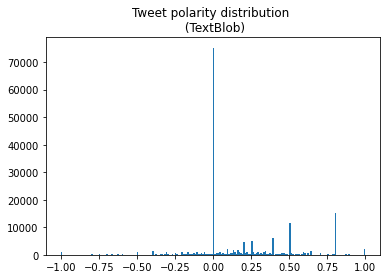

In [ ]:
plt.hist(x=sa_TB, bins=200, range=(-1,1))
plt.title("Tweet polarity distribution \n (TextBlob)")
plt.show()

In [ ]:
# Using Vader
analyzer = SentimentIntensityAnalyzer()
sa_V = []
t0 = time()
with open(DATA_FILE) as f:
    for i, line in enumerate(f):
        if i % 10000 == 0: # progress tracker
            print(f"\r Progress: {i//1000}k tweets processed", end="")
        tweet = json.loads(line)
        try:
            text = tweet["full_text"]
        except:
            text = tweet["text"]
        p = analyzer.polarity_scores(text)
        sa_V.append(p["compound"])
    t1=time()
    print(f"\r{i+1} tweets processed{' '*20}")
    print(f"wall time = {round(t1-t0,2)} seconds")
sa_V = np.array(sa_V)

175078 tweets processed                    
wall time = 42.05 seconds


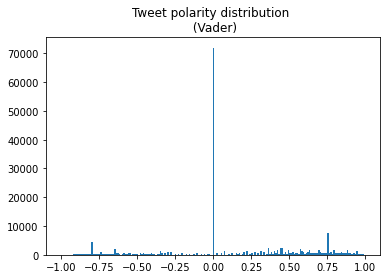

In [ ]:
plt.hist(x=sa_V, bins=200, range=(-1,1))
plt.title("Tweet polarity distribution \n (Vader)")
plt.show()

In [ ]:
print(f"TextBlob: \n {sum(sa_TB >= .05)} positive \n {sum(sa_TB <= -.05)} negative")
print("\n")
print(f"Vader: \n {sum(sa_V >= .05)} positive \n {sum(sa_V <= -.05)} negative")

TextBlob: 
 78716 positive 
 17618 negative


Vader: 
 69247 positive 
 32886 negative


Vader yields a more balanced sentiment distribution than TextBlob, which is desirable.  

**Note:** the discrepancy between TextBlob and Vader's sentiment analysis is concerning and probably worth a deeper look.  We might consider setting stricter thresholds than +/- 0.05

---
# Data filtering

## User filtering



In [ ]:
# create dictionary with number of tweets(in this dataset) and follower count for each user
users = {}

with open(DATA_FILE) as f:
    for i, line in enumerate(f):
        if i % 10000 == 0: # progress tracker
            print(f"\r Progress: {i//1000}k tweets processed", end="")
        tweet = json.loads(line)
        user = tweet["user"]
        user_id = user["id"]
        if user_id not in users:
            users[user_id] = {
                "tweet_count": 0,
                "followers_count": user["followers_count"]
            }
        users[user_id]["tweet_count"] += 1
    print(f"\r{' '*50}", end="\r") #clear progress tracker
    print(f" {i+1} total Tweets processed \n {len(users)} users found")

 175078 total Tweets processed 
 104772 users found


In [ ]:
# Most influential users
influential_user_ids = [415859364, 300114634, 16252784] #Nike, Adidas, and Lululemon

#user filtering criteria
min_tweet_count = 5
min_followers_count = 100000

for user_id, user in users.items():
    if user["tweet_count"] >= min_tweet_count and \
             user["followers_count"] >= min_followers_count:
        influential_user_ids.append(user_id)

print(f'{len(influential_user_ids)} "influential users" meet the specified criteria')

48 "influential users" meet the specified criteria


In [ ]:
# lower popularity requirements
included_user_ids = [415859364, 300114634, 16252784] #Nike, Adidas, and Lululemon

#user filtering criteria
min_tweet_count = 1
min_followers_count = 5000

for user_id, user in users.items():
    if user["tweet_count"] >= min_tweet_count and \
             user["followers_count"] >= min_followers_count:
        included_user_ids.append(user_id)

print(f'{len(included_user_ids)} users meet the specified criteria')

6562 users meet the specified criteria


## Tweet filtering


In [ ]:
#"influential users" tweets for Mentions Graph
with open(DATA_FILE) as f:
    influential_tweets = list(filter_tweets(f, user_ids=influential_user_ids))
print(f"Influential user tweets: \n {len(influential_tweets)} tweets meet filter criteria")

Influential user tweets: 
 532 tweets meet filter criteria


In [ ]:
# tweet subset for Semantic Graph (no sentiment analysis)
with open(DATA_FILE) as f:
    selected_tweets = list(filter_tweets(f, user_ids=included_user_ids))
    
print(f"Relaxed popularity requirements: \n {len(selected_tweets)} tweets meet filter criteria")

Relaxed popularity requirements: 
 20586 tweets meet filter criteria


In [ ]:
# tweet subset for Semantic Graph (POSITIVE sentiment)
with open(DATA_FILE) as f:
    positive_tweets = list(filter_tweets(f, user_ids=included_user_ids,
                                         min_polarity= 0.05 ))
    
print(f"Positive tweets: \n {len(positive_tweets)} tweets meet filter criteria")

Positive tweets: 
 6892 tweets meet filter criteria


In [ ]:
# tweet subset for Semantic Graph (NEGATIVE sentiment)
with open(DATA_FILE) as f:
    negative_tweets = list(filter_tweets(f, user_ids=included_user_ids,
                                         max_polarity= -0.05 ))
    
print(f"Negative tweets: \n {len(negative_tweets)} tweets meet filter criteria")

Negative tweets: 
 2639 tweets meet filter criteria


---
# Mentions network analysis

## Constructing the mentions graph


In [ ]:
G_mentions = nx.DiGraph()

for tweet in influential_tweets:
    sender_id = tweet["user"]["id"]
    sender_name = tweet["user"]["screen_name"]
    for mention in tweet["entities"]["user_mentions"]:
        receiver_name = mention["screen_name"]
        receiver_id = mention["id"]
        if (receiver_id in influential_user_ids) and (receiver_id != sender_id): # exclude self-loops
            if G_mentions.has_edge(sender_name, receiver_name):
                G_mentions.edges[sender_name, receiver_name]["weight"] += 1
            else:
                G_mentions.add_edge(sender_name, receiver_name, weight=1, color="black")

nx.info(G_mentions)

'DiGraph with 48 nodes and 85 edges'

In [ ]:
#initialize node location for 3 brands
fixed_pos = {"adidas": (0,1),
             "Nike": (0,-1),
             "lululemon": (-1.732,0)}
fixed_nodes = [node for node in fixed_pos.keys()]

# calculate node positions.  
pos = nx.spring_layout(G_mentions, 
                       weight="weight", 
                       pos=fixed_pos,
                       fixed=fixed_nodes, #keep these nodes at their initial locations
                       k=1, 
                       seed=1)

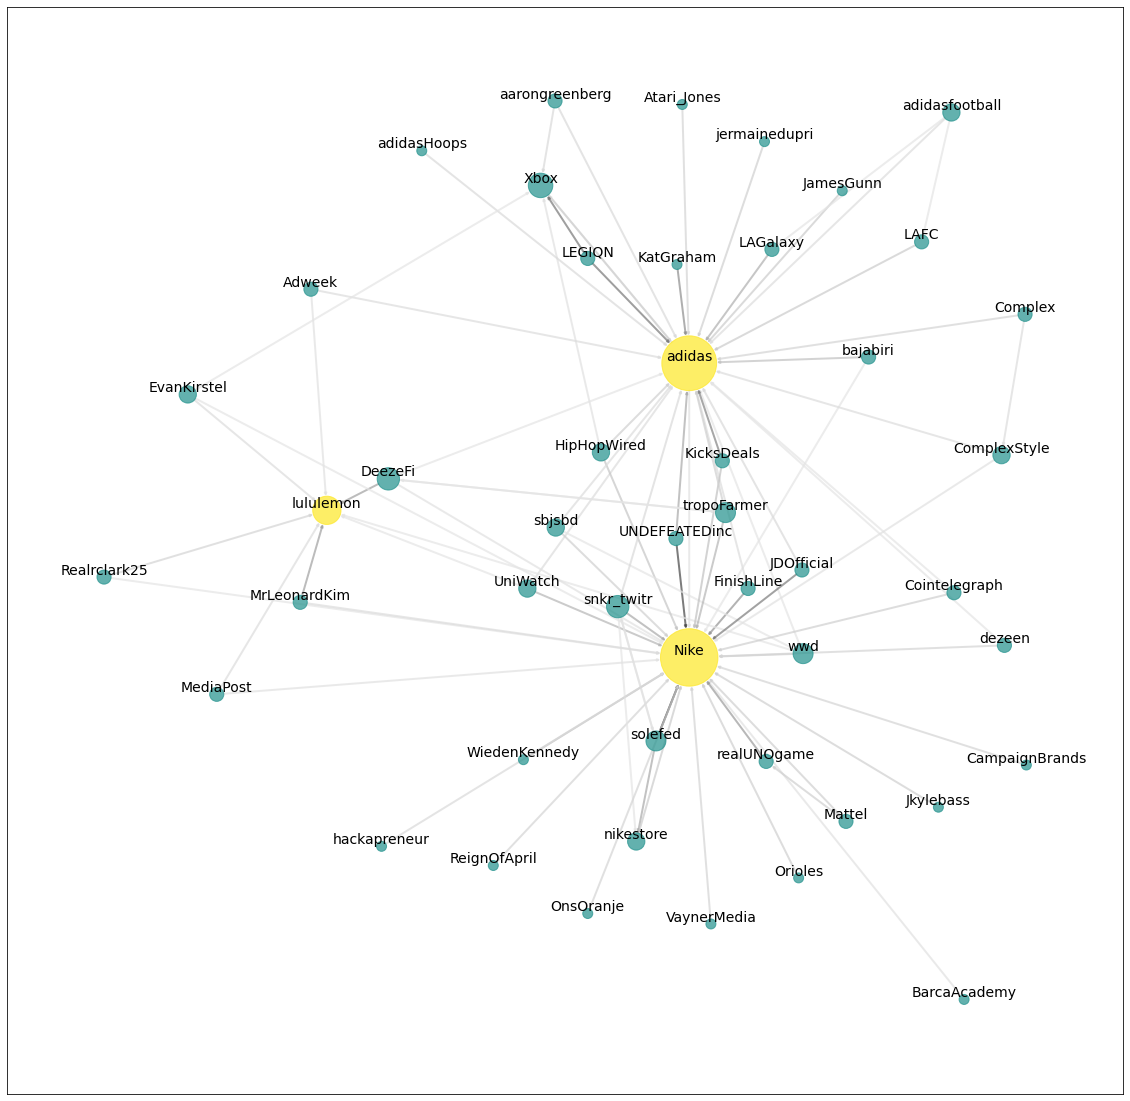

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

#set node colors
val_map = { "Nike": 1.0,
            "adidas": 1.0,
            "lululemon": 1.0}
node_colors = [val_map.get(node, .5) for node in G_mentions.nodes()]

#set node sizes
scale_factor = 100
scaled_degrees = [degree*scale_factor for node, degree in G_mentions.degree]

edge_colors = np.array([w for (u, v, w) in G_mentions.edges.data('weight')])
edge_colors = edge_colors/np.max(edge_colors)


edge_widths = [w for (u, v, w) in G_mentions.edges.data('weight')]

nx.draw_networkx(G_mentions, pos=pos, ax=ax, 
        with_labels=False,
        font_size=14, 
        node_size = scaled_degrees, 
        node_color= node_colors,  
        alpha=0.7,
        cmap="viridis",
        vmin=0,
        vmax=1,
        width=2,
        edge_cmap=plt.cm.Greys,
        edge_color=edge_colors,
        edge_vmin=-.2,
        edge_vmax=1,
        arrowsize=4
        )

### manually add vertical offset to the label position
# label_pos = {node: [coord[0], coord[1]+.05] for node, coord in pos.items()}
nx.draw_networkx_labels(G_mentions, ax=ax,
                        # pos=label_pos,
                        pos=pos,
                        verticalalignment="bottom",
                        font_size = 14
                        )
plt.show()


## Pyvis: interactive visualization of mentions graph


In [ ]:
%%capture
!pip install pyvis
from pyvis.network import Network
from IPython.core.display import display, HTML

GRAPH_DIR = PROJECT_DIR+"/Graphs/"

In [ ]:
### set color of Nike, adidas, and lululemon's nodes
for _ in ["Nike", "adidas", "lululemon"]:
    G_mentions.nodes[_]["color"] = "yellow"

## set color of bridge nodes (nodes which connect ALL 3 brands)
bridge_set = set(["Nike", "adidas", "lululemon"])
for node in G_mentions.adj:
    if bridge_set.issubset(set(G_mentions.adj[node])): 
        G_mentions.nodes[node]["color"] = "purple"

### Node titles
for label in G_mentions.nodes:
    G_mentions.nodes[label]["title"] = label

In [ ]:
graph_filename = "nx_mentions.html"
nt = Network('800px', '800px', 
             notebook=True, 
             cdn_resources="remote", 
             neighborhood_highlight=True
            )
nt.from_nx(G_mentions, 
           show_edge_weights=False, 
           edge_scaling=False)
nt.toggle_physics(True)
nt.show_buttons(filter_=["physics"])
nt.save_graph(GRAPH_DIR+graph_filename)
nt.show(graph_filename)
display(HTML(graph_filename))


## Top-10 most central users 
* in-degree centrality
* calculated with full dataset

In [ ]:
G_full = nx.DiGraph()

with open(DATA_FILE) as f:
    for i, line in enumerate(f):
        if i % 10000 == 0:
            print(f"\r Prcessed {(i+1)//1000}k tweets", end="")
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        sender_name = tweet["user"]["screen_name"]
        for mention in tweet["entities"]["user_mentions"]:
            receiver_name = mention["screen_name"]
            receiver_id = mention["id"]
            if (receiver_id != sender_id) and not G_full.has_edge(sender_name, receiver_name):
                G_full.add_edge(sender_name, receiver_name)

nx.info(G_full)

 Prcessed 170k tweets

'DiGraph with 127789 nodes and 302884 edges'

In [ ]:
centrality_dict = nx.in_degree_centrality(G_full)
R = G_full.reverse() #reversed graph necessary for finding incoming nodes
lulu_dict = {node: centrality_dict[node] for node, _ in R.adj["lululemon"].items()}
nike_dict = {node: centrality_dict[node] for node, _ in R.adj["Nike"].items()} 
adidas_dict = {node: centrality_dict[node] for node, _ in R.adj["adidas"].items()}

In [ ]:
print("Lululemon: Top 10 central users \n")
dict(sorted(lulu_dict.items(), key=lambda x: x[1], reverse=True)[:10])

Lululemon: Top 10 central users 



{'PredsNHL': 0.0011425172942686325,
 'turtlepace5': 0.0011033899896703916,
 'HookTSB': 0.0006338623344915016,
 'calvinmcdonald': 0.0006182114126522052,
 'UniWatch': 0.0006025604908129089,
 'DeezeFi': 0.0006025604908129089,
 'hockeynight': 0.0005399568034557236,
 'NicholasFerroni': 0.00035214574138416754,
 'Realrclark25': 0.000328669358625223,
 'DirectorJayC': 0.0003208438977055749}

In [ ]:
print("Nike: Top 10 central users \n")
dict(sorted(nike_dict.items(), key=lambda x: x[1], reverse=True)[:10])

Nike: Top 10 central users 



{'adidas': 0.2183694869627821,
 'KingJames': 0.04217923435690362,
 'theestallion': 0.037804801702820294,
 'Jumpman23': 0.03023758099352052,
 'nikestore': 0.020127085485335088,
 'snkr_twitr': 0.008075875669076908,
 'LFC': 0.007535918865621185,
 'nikebasketball': 0.006369925188593608,
 'Giannis_An34': 0.005783015619619996,
 'Topps': 0.005031771371333772}

In [ ]:
print("Adidas: Top 10 central users \n")
dict(sorted(adidas_dict.items(), key=lambda x: x[1], reverse=True)[:10])

Adidas: Top 10 central users 



{'Xbox': 0.05872225874103985,
 'adidasFballUS': 0.054089585876608136,
 'adidasoriginals': 0.013905844054214793,
 'snkr_twitr': 0.008075875669076908,
 'Hyperkin': 0.00773155538861239,
 'SCCTradingCards': 0.004922214918458697,
 'boardroom': 0.0041240179046545845,
 'nicekicks': 0.003615362944877453,
 'adidasHoops': 0.003357122734529064,
 'richsignorelli': 0.003255391742573638}

---
# Semantic network analysis



## Semantic Network Graph

In [ ]:
# Make word count dictionary for "selected_tweets" corpus
word_counts = {}

stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords.update("rt three like one max try year day http".split()) ## manually added words that weren't useful

for tweet in selected_tweets:
    text = tweet["full_text"]
    tokens = tokenize(text, lowercase=True)
    tokens = remove_links(tokens)
    tokens = remove_stopwords(tokens, stopwords=stopwords)
    tokens = remove_handles(tokens)
    tokens = remove_punctuation(tokens, strict=True)
    tokens = lemmatize(tokens) 
    tokens = remove_short(tokens, min_length=4)
    for word in tokens:
        word_counts[word] = word_counts.get(word, 0) + 1

print(f"{len(word_counts)} tokens found")

12872 tokens found


In [ ]:
print(f'''
Brand token counts: \n 
 Nike: {word_counts["nike"]} \n
 Adidas: {word_counts["adidas"]} \n
 Lululemon: {word_counts["lululemon"]}
''')


Brand token counts: 
 
 Nike: 23542 

 Adidas: 3011 

 Lululemon: 745



85256 tokens found

In [ ]:
sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_words = [word for word, count in sorted_counts]

N=50
top_terms = sorted_words[:N]
G = nx.Graph()
#scale edgeweights to account for unequal brand mentions
# brand_scaling = {"nike": word_counts["nike"]/word_counts["nike"],
#                  "adidas": word_counts["nike"]/word_counts["adidas"],
#                  "lululemon": word_counts["nike"]/word_counts["lululemon"]}
            
for tweet in selected_tweets:
    text = tweet["full_text"]
    tokens = tokenize(text, lowercase=True)
    tokens = remove_links(tokens)
    tokens = remove_stopwords(tokens, stopwords=stopwords)
    tokens = remove_punctuation(tokens, strict=True)
    tokens = lemmatize(tokens) 
    tokens = remove_short(tokens, min_length=2)

    nodes = set([t for t in tokens if t in top_terms])
    cooccurrences = itertools.combinations(nodes, 2)
    for edge in cooccurrences:
        if G.has_edge(*edge):
            G.edges[edge]["weight"] += 1
        else: 
            G.add_edge(*edge, weight=1)



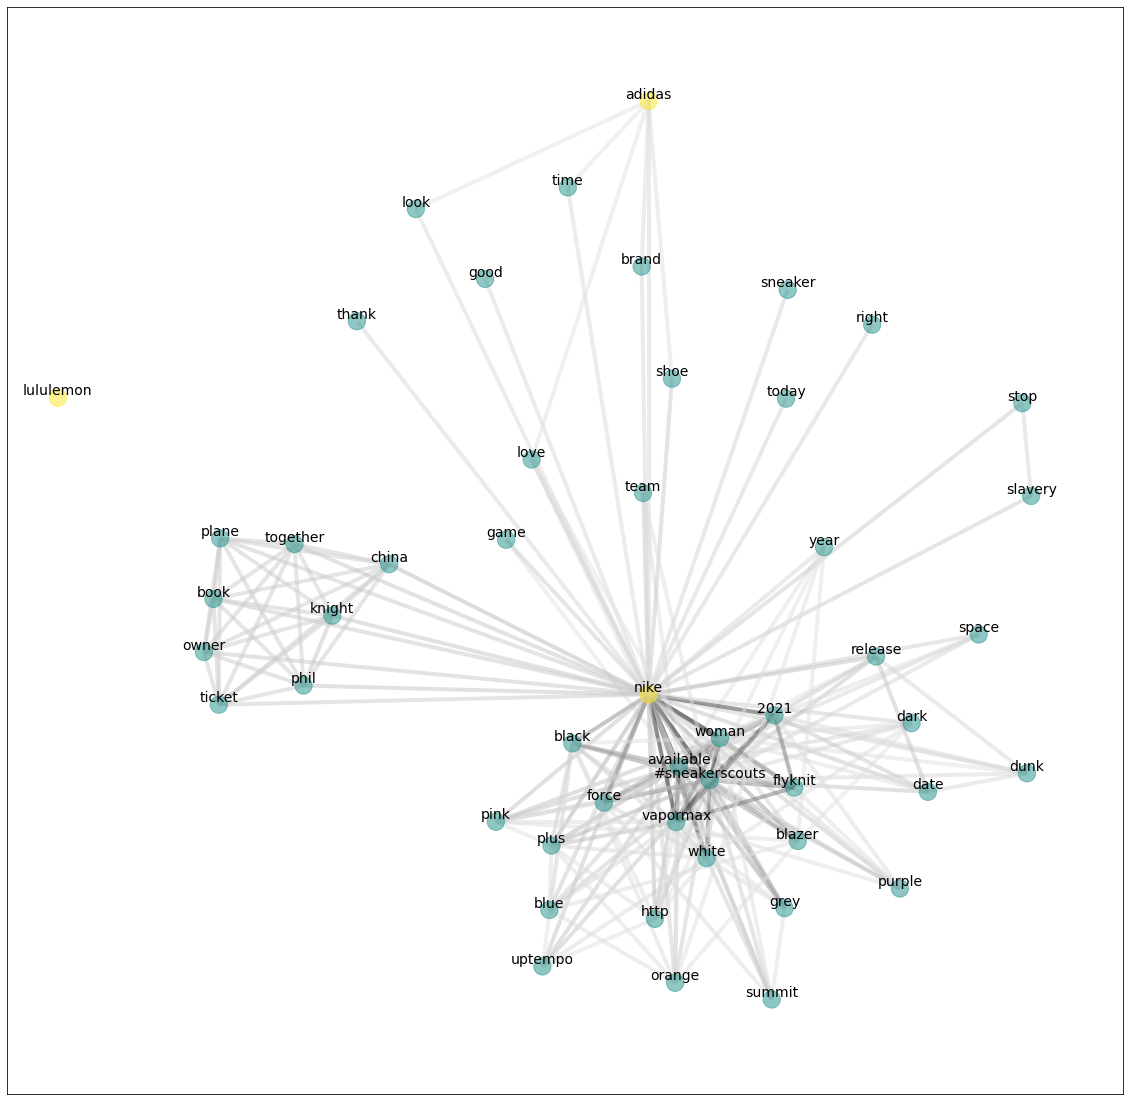

In [ ]:
# # initialize locations of brand nodes 
fixed_pos = {"adidas": (0,1),
             "nike": (0,-1),
             "lululemon": (-1.732,0)}
fixed_nodes = [node for node in fixed_pos.keys()]

# calculate node positions.  
pos = nx.spring_layout(G, 
                       weight="weight", 
                       pos=fixed_pos,
                       fixed=fixed_nodes,
                       k=3,
                       seed=1)

#set node colors
val_map = { "nike": 1.0,
            "adidas": 1.0,
            "lululemon": 1.0}
node_colors = [val_map.get(node, .5) for node in G.nodes()]


### select which edges to draw, and decide how dark to shade them
edge_threshold = 0.01 ## only draw edges with normalized weights exceeding this value
edge_colors = np.array([w for (u, v, w) in G.edges.data('weight')])
edge_colors = edge_colors/np.max(edge_colors)


edge_list = [edge for edge, c in zip(G.edges, edge_colors) if c > edge_threshold]
edge_colors = [c for c in edge_colors if c > edge_threshold]


fig, ax = plt.subplots(1, 1, figsize=(20, 20))
nx.draw_networkx(G, pos=pos, ax=ax, 
        with_labels=False,
        font_size=14, 
        node_color= node_colors,
        alpha=0.5,
        cmap="viridis",
        vmin=0,
        vmax=1,
        edge_cmap=plt.cm.Greys,
        edge_color=edge_colors,
        edgelist=edge_list,
        edge_vmin=-.05,
        edge_vmax=.25,
        width=4,
        arrowsize=4
        )

nx.draw_networkx_labels(G, ax=ax,
                        pos=pos,
                        verticalalignment="bottom",
                        font_size = 14
                        )

plt.show()


## Semantic Network Graph: **POSITIVE** Sentiment

**Note:** tweet sentiment determined by the [VADER](https://github.com/cjhutto/vaderSentiment) sentiment analysis tool.  Tweets with a compound score >= 0.05 are included in this subset (as recommended in the VADER documentation).

In [ ]:
# Make word count dictionary for "positive_tweets" corpus
word_counts = {}

stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords.update("rt three like one max try year day http".split()) ## manually added words that weren't useful

for tweet in positive_tweets:
    text = tweet["full_text"]
    tokens = tokenize(text, lowercase=True)
    tokens = remove_links(tokens)
    tokens = remove_stopwords(tokens, stopwords=stopwords)
    tokens = remove_handles(tokens)
    tokens = remove_punctuation(tokens, strict=True)
    tokens = lemmatize(tokens) 
    tokens = remove_short(tokens, min_length=4)
    for word in tokens:
        word_counts[word] = word_counts.get(word, 0) + 1

print(f"{len(word_counts)} tokens found")

8863 tokens found


In [ ]:
print(f'''
Brand token counts: \n 
 Nike: {word_counts["nike"]} \n
 Adidas: {word_counts["adidas"]} \n
 Lululemon: {word_counts["lululemon"]}
''')


Brand token counts: 
 
 Nike: 5313 

 Adidas: 1586 

 Lululemon: 448



In [ ]:
sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_words = [word for word, count in sorted_counts]

N=40
top_terms = sorted_words[:N]
G_positive = nx.Graph()

            
for tweet in positive_tweets:
    text = tweet["full_text"]
    tokens = tokenize(text, lowercase=True)
    tokens = remove_links(tokens)
    tokens = remove_stopwords(tokens, stopwords=stopwords)
    tokens = remove_punctuation(tokens, strict=True)
    tokens = lemmatize(tokens) 
    tokens = remove_short(tokens, min_length=2)

    nodes = set([t for t in tokens if t in top_terms])
    cooccurrences = itertools.combinations(nodes, 2)
    for edge in cooccurrences:
        if G_positive.has_edge(*edge):
            G_positive.edges[edge]["weight"] += 1
        else: 
            G_positive.add_edge(*edge, weight=1)

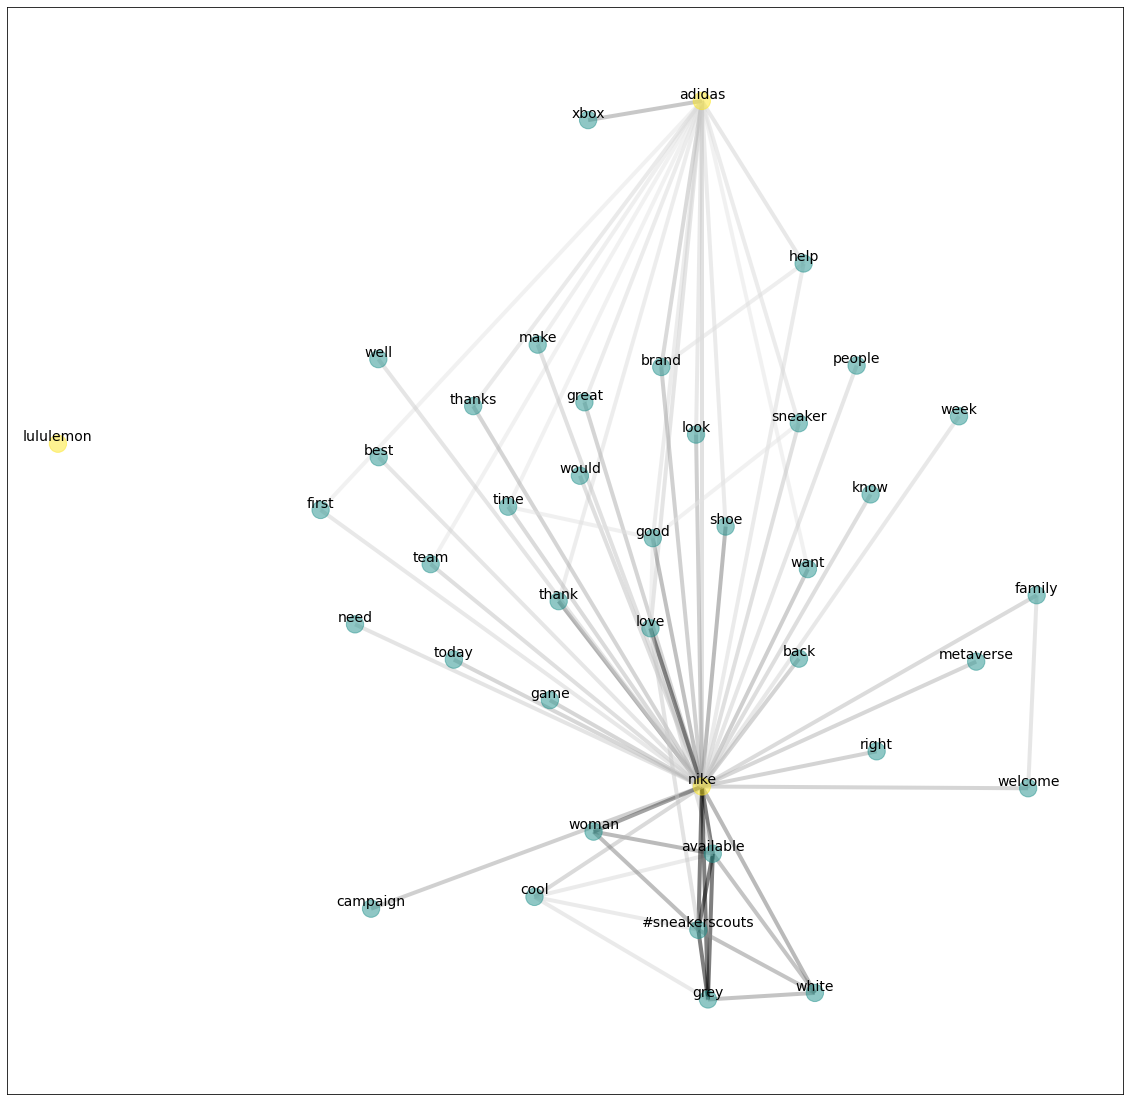

In [ ]:
# # initialize locations of brand nodes 
fixed_pos = {"adidas": (0,1),
             "nike": (0,-1),
             "lululemon": (-1.732,0)}
fixed_nodes = [node for node in fixed_pos.keys()]

# calculate node positions.  
pos = nx.spring_layout(G_positive, 
                       weight="weight", 
                       pos=fixed_pos,
                       fixed=fixed_nodes,
                       k=2,
                       seed=1)

#set node colors
val_map = { "nike": 1.0,
            "adidas": 1.0,
            "lululemon": 1.0}
node_colors = [val_map.get(node, .5) for node in G_positive.nodes()]


### select which edges to draw, and decide how dark to shade them
edge_threshold = 0.05 ## only draw edges with normalized weights exceeding this value
edge_colors = np.array([w for (u, v, w) in G_positive.edges.data('weight')])
edge_colors = edge_colors/np.max(edge_colors)

edge_list = [edge for edge, c in zip(G_positive.edges, edge_colors) if c > edge_threshold]
edge_colors = [c for c in edge_colors if c > edge_threshold]

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
nx.draw_networkx(G_positive, pos=pos, ax=ax, 
        with_labels=False,
        font_size=14, 
        node_color= node_colors,
        alpha=0.5,
        cmap="viridis",
        vmin=0,
        vmax=1,
        edge_cmap=plt.cm.Greys,
        edge_color=edge_colors,
        edgelist=edge_list,
        edge_vmin=-.05,
        edge_vmax=.5,
        width=4,
        arrowsize=4
        )

nx.draw_networkx_labels(G_positive, ax=ax,
                        pos=pos,
                        verticalalignment="bottom",
                        font_size = 14
                        )

plt.show()


## Semantic Network Graph: **NEGATIVE** Sentiment

**Note:** tweet sentiment determined by the [VADER](https://github.com/cjhutto/vaderSentiment) sentiment analysis tool.  Tweets with a compound score <= -0.05 are included in this subset (as recommended in the VADER documentation).

In [ ]:
# Make word count dictionary for "negative_tweets" corpus
word_counts = {}

stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords.update("rt three like one max try year day http".split()) ## manually added words that weren't useful

for tweet in negative_tweets:
    text = tweet["full_text"]
    tokens = tokenize(text, lowercase=True)
    tokens = remove_links(tokens)
    tokens = remove_stopwords(tokens, stopwords=stopwords)
    tokens = remove_handles(tokens)
    tokens = remove_punctuation(tokens, strict=True)
    tokens = lemmatize(tokens) 
    tokens = remove_short(tokens, min_length=4)
    for word in tokens:
        word_counts[word] = word_counts.get(word, 0) + 1

print(f"{len(word_counts)} tokens found")

4354 tokens found


In [ ]:
print(f'''
Brand token counts: \n 
 Nike: {word_counts["nike"]} \n
 Adidas: {word_counts["adidas"]} \n
 Lululemon: {word_counts["lululemon"]}
''')


Brand token counts: 
 
 Nike: 2569 

 Adidas: 390 

 Lululemon: 69



In [ ]:
sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_words = [word for word, count in sorted_counts]

N=40
top_terms = sorted_words[:N]
G_negative = nx.Graph()

            
for tweet in negative_tweets:
    text = tweet["full_text"]
    tokens = tokenize(text, lowercase=True)
    tokens = remove_links(tokens)
    tokens = remove_stopwords(tokens, stopwords=stopwords)
    tokens = remove_punctuation(tokens, strict=True)
    tokens = lemmatize(tokens) 
    tokens = remove_short(tokens, min_length=2)

    nodes = set([t for t in tokens if t in top_terms])
    cooccurrences = itertools.combinations(nodes, 2)
    for edge in cooccurrences:
        if G_negative.has_edge(*edge):
            G_negative.edges[edge]["weight"] += 1
        else: 
            G_negative.add_edge(*edge, weight=1)

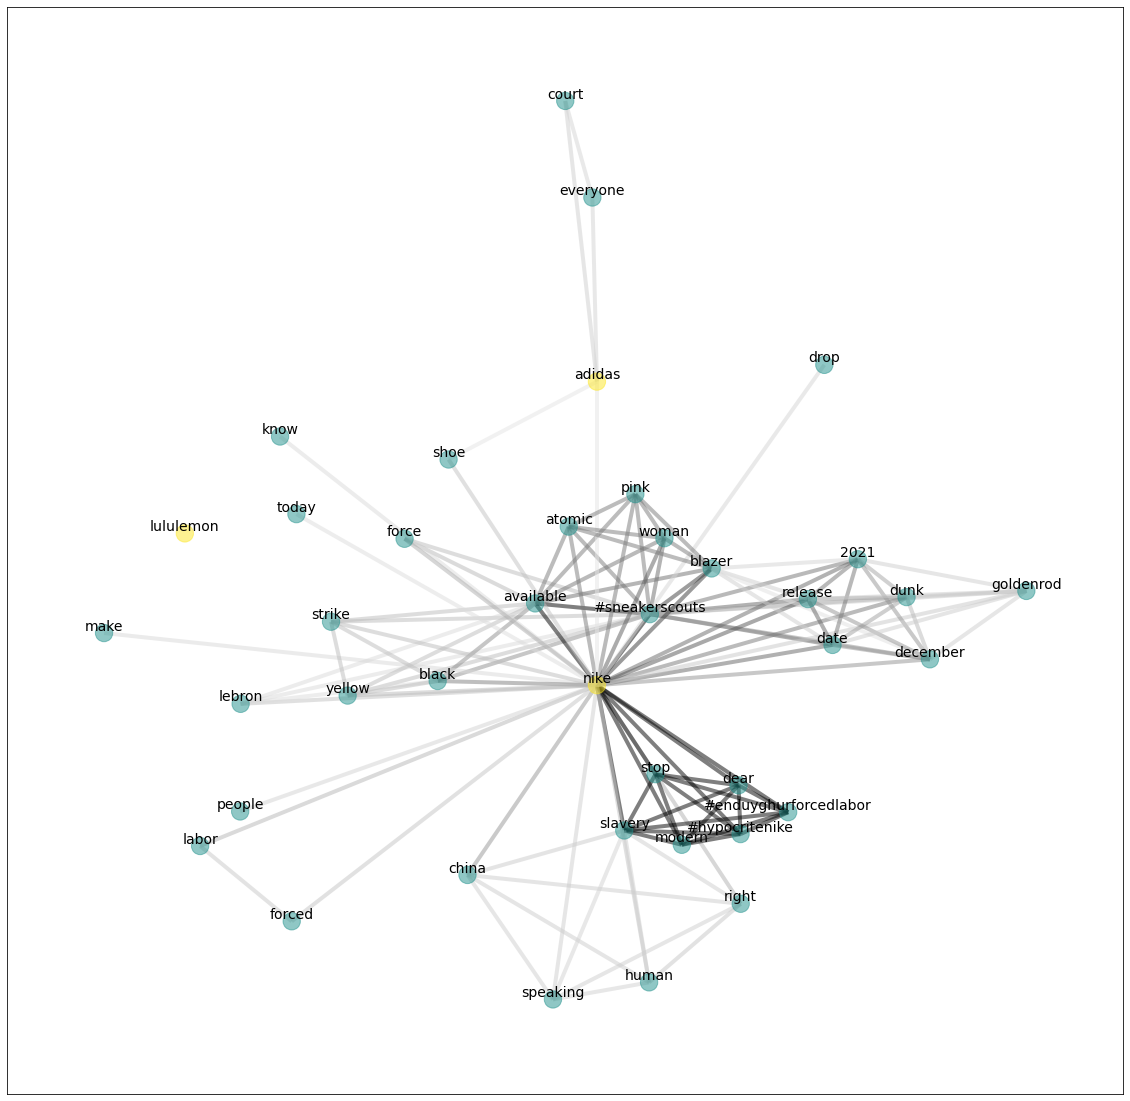

In [ ]:
# # initialize locations of brand nodes 
fixed_pos = {"adidas": (0,1),
             "nike": (0,-1),
             "lululemon": (-1.732,0)}
fixed_nodes = [node for node in fixed_pos.keys()]

# calculate node positions.  
pos = nx.spring_layout(G_negative, 
                       weight="weight", 
                       pos=fixed_pos,
                       fixed=fixed_nodes,
                       k=3,
                       seed=1)

#set node colors
val_map = { "nike": 1.0,
            "adidas": 1.0,
            "lululemon": 1.0}
node_colors = [val_map.get(node, .5) for node in G_negative.nodes()]


### select which edges to draw, and decide how dark to shade them
edge_threshold = 0.05 ## only draw edges with normalized weights exceeding this value
edge_colors = np.array([w for (u, v, w) in G_negative.edges.data('weight')])
edge_colors = edge_colors/np.max(edge_colors)

edge_list = [edge for edge, c in zip(G_negative.edges, edge_colors) if c > edge_threshold]
edge_colors = [c for c in edge_colors if c > edge_threshold]

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
nx.draw_networkx(G_negative, pos=pos, ax=ax, 
        with_labels=False,
        font_size=14, 
        node_color= node_colors,
        alpha=0.5,
        cmap="viridis",
        vmin=0,
        vmax=1,
        edge_cmap=plt.cm.Greys,
        edge_color=edge_colors,
        edgelist=edge_list,
        edge_vmin=-.05,
        edge_vmax=.5,
        width=4,
        arrowsize=4
        )

nx.draw_networkx_labels(G_negative, ax=ax,
                        pos=pos,
                        verticalalignment="bottom",
                        font_size = 14
                        )

plt.show()
